In [1]:
# Deborah Lokhorst

# This example is an exploration of the interactions between a planet and a ring of massive
# particles.  It is intended to show the perturbation of the ring of particles, as well as 
# the ring's effect on the planet.

# Much of the code of this example is based off of and taken from the spreading_ring in C 
# and SaturnsRings.ipynb.

import rebound
import numpy as np
sim = rebound.Simulation()

In [2]:
sim.G = 1
sim.dt = 1.0e-2*2.*np.pi # 1% of an orbit
#sim.N_active = 2
sim.softening = 0.01
sim.integrator = "leapfrog"
sim.boundary   = "open"
sim.gravity    = "tree"
sim.collision  = "tree"
boxsize = 4.8    # 4.8
sim.configure_box(boxsize,32,32,32)

N_particles = 10000
sim.add(id = 1,m=1.)
sim.add(id = 2,m=1.0e-2,a=1.)  # added another body in there.  changed n_active to 2.
sim.move_to_com()

In [3]:
print sim.particles[0].id,sim.particles[0].y
print sim.particles[1].id,sim.particles[1].y

1 0.0
2 0.0


In [4]:
# I wanted to implement a disk of particles, distributed according to a power law.
# The surface density is intended to end up as a power law with exponent of -3/2.
def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

N=0
while(N < N_particles):
    a   = powerlaw(slope=0.5,min_v = 0.9,max_v = 1.1)
    phi = np.random.uniform(low = 0,high = 2.*np.pi)
    vkep = np.sqrt(1./a) 
    sim.add(
        x = a*np.cos(phi),
        y = a*np.sin(phi),
        z = a*np.random.normal(0.0001),
        vx =  vkep * np.sin(phi),
        vy = -vkep * np.cos(phi),
        m = 0.0001,
        r = .3/np.sqrt(N_particles))
    N += 1
    
# 4% of the particles I try to add give me the error: Warning! Did not add particle outside of box boundaries
#-- turns out to be in the z-direction... went away when increased box size in z-direction

In [5]:
print sim.particles[0].id,sim.particles[0].x
print sim.N

1 -0.00990099009901
10002


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plotParticles(sim):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_ylabel("y [AU]")
    ax.set_xlabel("x [AU]")
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):
        circ = patches.Circle((p.x, p.y), p.r, facecolor='darkgray', edgecolor='black')
        ax.add_patch(circ)
        

plotParticles(sim) # takes about 20 seconds to plot

plt.plot(sim.particles[0].x,sim.particles[0].y,'yo')
plt.plot(sim.particles[1].x,sim.particles[1].y,'bo')

In [7]:
# Let's integrate for one orbit and see what the disk of particles looks like after that.

sim.integrate(2.*np.pi)  # takes about 16 seconds per orbit when particles have mass
#sim.N
#sim.particles[0].m

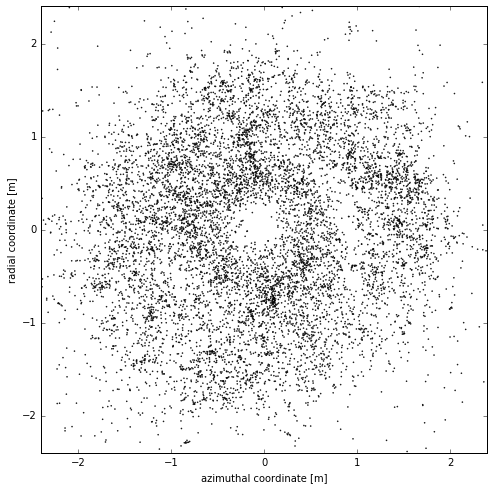

In [8]:
plotParticles(sim)
# Plot of particle locations:

In [33]:
# Unfortunately, if REBOUND is able to print a particle's orbit and intrinsic parameters
# based on the ID I assigned it, I was unable to find out how.
# Room for improvement of the code or better instructions in the documentation: the ability to 
# keep track of particles with ID numbers, so that I have a pointer to their parameters.

# This is needed because after integration with so many particles, it appears that the 
# order of particles is all mixed up.  So the particle with index = 0 is now very unlikely 
# to be the Sun, as it was set in the beginning.  (Any way to avoid this?  I tried making the
# simulation box bigger so that no particles were removed from the simulation, but it didn't help.)

# Though, of course, the C implementation is probably much faster, so it might not be worth
# it to go through the effort for just the python version.

# Anyways, in order to find my sun and my planet, I loop through all the particles and search
# for the particles with my ID numbers... This takes a lot of time!! 
# If there is a fast and easy way to do this, I don't know what it is, but it'd be great.

# I output every 100 iterations with the number of particles we are at.

def findIndex(sim):
    sunID = -1
    planetID = -1
    print "progress (out of "+str(sim.N)+"):"
    #finding the sun by ID number
    for i in range(sim.N):
        if i%100 == 0:
            print i
        if sim.particles[i].id == 2:
            planetID = i
        if sim.particles[i].id == 1:
            sunID = i
            break
        
    #finding the planet by ID number
    if planetID == -1:
        print "planet ?"
        for j in range(i,sim.N):
            if j%100 == 0:
                print j
            if sim.particles[j].id == 2:
                planetID = j
                break
    return [sunID,planetID]

[sunID,planetID] = findIndex(sim)

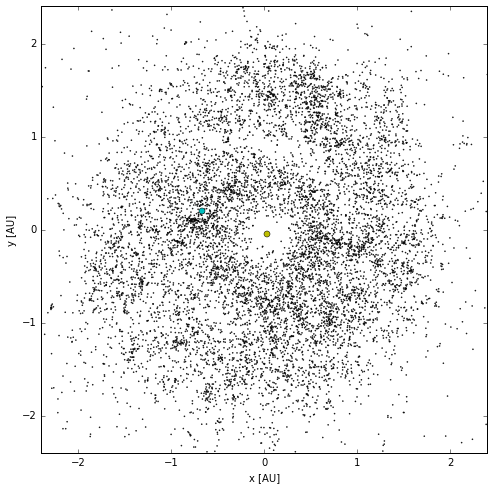

In [28]:
plotParticles(sim)
plt.plot(sim.particles[sunID].x,sim.particles[sunID].y,'yo') #sun
plt.plot(sim.particles[planetID].x,sim.particles[planetID].y,'co') # planet

# Plot of particle locations with planet and sun highlighted:

In [29]:
# new semi-major axis of the planet
# distance from the planet to the sun
x = sim.particles[planetID].x-sim.particles[sunID].x
y = sim.particles[planetID].y-sim.particles[sunID].y
z = sim.particles[planetID].z-sim.particles[sunID].z
print np.sqrt(x**2 + y**2 + z**2)
print sim.particles[planetID].a

0.743201379214
-0.114075540262


In [30]:
# As you can see, the planet has moved inwards from interactions with the disk of particles!
# Originally at a distance of 1 AU from the central mass, it has moved in to a distance of
# 0.74 AU (this will change values each time you run this, but statistically, the planet should
# move inwards.  I can't test this myself because it would take
# a very long time-- longer than a few minutes, that's for sure.)

# You can also see that the disk has been quite perturbed by the orbiting planet, forming
# lovely density dips at the radius of the planet's orbit.

In [39]:
# Let's integrate for a few more orbits and see what happens to the planet and disk after that.

sim.integrate(2.*np.pi*5.)  # takes about 16 seconds per orbit

In [41]:
# One last time, let's look for the sun and the planet within our muddle of particles.
[sunID,planetID] = findIndex(sim)

progress (out of 9986):
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


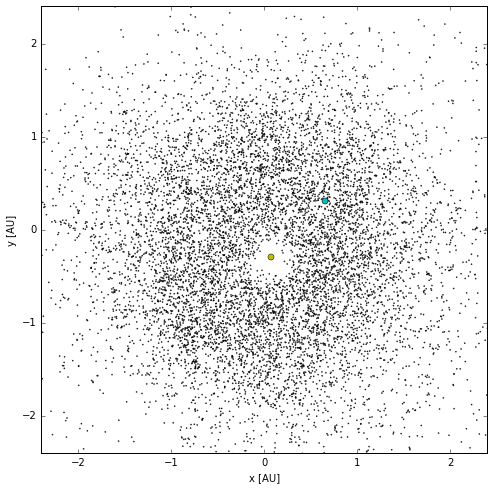

In [42]:
# Let's again plot the simulation with the sun and planet highlighted.
plotParticles(sim)
plt.plot(sim.particles[sunID].x,sim.particles[sunID].y,'yo') #sun
plt.plot(sim.particles[planetID].x,sim.particles[planetID].y,'co') # planet

In [43]:
# new semi-major axis of the planet
# distance from the planet to the sun
x = sim.particles[planetID].x-sim.particles[sunID].x
y = sim.particles[planetID].y-sim.particles[sunID].y
z = sim.particles[planetID].z-sim.particles[sunID].z
print np.sqrt(x**2 + y**2 + z**2)
print sim.particles[planetID].a

0.843736932446
-0.129554514665


In [ ]:
# Looks like the planet has migrated outwards a bit now.
# The disk has also smoothed out -- perhaps the initial density variation
# was also due to the spreading of the thin ring and the strong interactions
# when all the particles and the planet were on very close orbits.